Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
938/938 [==============================] - 560s 594ms/step - loss: 0.5099 - accuracy: 0.7484
model  ('nn0', <keras.engine.sequential.Sequential object at 0x7f1e4a98ae50>) added
938/938 [==============================] - 584s 620ms/step - loss: 0.5090 - accuracy: 0.7489
model  ('nn1', <keras.engine.sequential.Sequential object at 0x7f1e382b8090>) added
938/938 [==============================] - 587s 623ms/step - loss: 0.5057 - accuracy: 0.7516
model  ('nn2', <keras.engine.sequential.Sequential object at 0x7f1e2021fe10>) added
938/938 [==============================] - 616s 654ms/step - loss: 0.5077 - accuracy: 0.7489
model  ('nn3', <keras.engine.sequential.Sequential object at 0x7f1e3fbf8f90>) added
938/938 [==============================] - 5

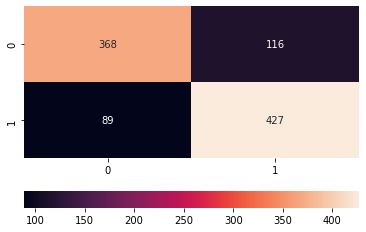

In [5]:
#import librarys and mount drive
import pandas as pd
from google.colab import drive
import numpy as np
import nltk
import gensim
from gensim.models import Word2Vec as w2v
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding , Dense , GRU
!pip install tensorflow
import tensorflow as tf
from sklearn.metrics import confusion_matrix , accuracy_score
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/437_semester_project/training_1600000.csv'

#load in dataset into 1 massive pandas dataframe
big_df = pd.read_csv(DATASET_PATH,encoding = 'latin',header=None)

#drop useless columns and relabel the labels
big_df = big_df.drop([1,2,3,4],axis = 1)
big_df = big_df.rename(columns={0:'label', 5:'text'})
big_df['label'] = big_df['label'].replace([4],1)

#make a smaller balanced df and jumble it up
neg_df = big_df[big_df['label'] == 0].iloc[:750000]
pos_df = big_df[big_df['label'] == 1].iloc[:750000]
small_df = pd.concat([neg_df,pos_df])
small_df = small_df.sample(frac=1).reset_index(drop=True)
def remove_stop_words(df):
  '''
  df: pandas dataframe with unproccessed tweets
  returns the same df with stop words removed
  '''
  nltk.download("stopwords")
  from nltk.corpus import stopwords
  sw = stopwords.words("english")
  new_text = pd.DataFrame(df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw)))
  df.text = new_text
  return df
stem_module = nltk.stem.PorterStemmer()
def stemmer(tweet):
  words = []
  tweet = tweet.split(" ")
  for word in tweet:
    #add tag
    if len(word) == 0:
      continue
    if word[0] == '@':
      words.append('___TAG____')
    #add link
    elif word[0:4] == 'http':
      words.append('___LINK___')
    #add stemmed word with special chars
    else:
      word = ''.join(filter(str.isalnum, word))
      words.append(stem_module.stem(word).lower().strip())
  return " ".join(words)


proccessed_df = remove_stop_words(small_df)
proccessed_df.text = proccessed_df.text.apply(lambda tweet: stemmer(tweet))

def to_2d(text):
    '''
      utility function that makes a string sentence into
       a 2d list of words
    '''
    words = []
    text = text.split(" ")
    for word in text:
      words.append(word)
    return words

#make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(proccessed_df['text'].apply(lambda text:  to_2d(text)))

#get seperate train/test/validation sets


def get_train_test_validation(df,max_tweet_words=280):
    #get a train , test and validation dataset 
    y = df['label']
    X = df.copy()#.drop(['is_automated'] , axis = 1)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_indexs  = sss.split(X, y)
    for train_index, test_index in sss.split(X, y):
        train_set = df.iloc[train_index]
        test_valid_set = df.iloc[test_index]
    test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
    for test_index, valid_index in test_split.split(test_valid_set, test_valid_set['label']):
        test_set = test_valid_set.iloc[test_index]
        valid_set = test_valid_set.iloc[valid_index]
    #get y output labels and make X be a tokenized list
    y_train = np.array(train_set['label'])
    x_train = tokenizer.texts_to_sequences(train_set['text'])
    x_train = pad_sequences(x_train,maxlen=280)
    y_test = np.array(test_set['label'])
    x_test = tokenizer.texts_to_sequences(test_set['text'])
    x_test = pad_sequences(x_test,maxlen=280)
    y_valid = np.array(valid_set['label'])
    x_valid = tokenizer.texts_to_sequences(valid_set['text'])
    x_valid = pad_sequences(x_valid,maxlen=280)
    y_train = y_train.reshape(y_train.shape[0],)
    y_test = y_test.reshape(y_test.shape[0],)
    y_valid = y_valid.reshape(y_valid.shape[0],)
    return np.array(y_train),x_train,y_valid,x_valid,y_test,x_test
y_train,x_train,y_valid,x_valid,y_test,x_test = get_train_test_validation(proccessed_df)

max_locs = np.where(x_train == np.amax(x_train))
num_words = x_train[max_locs[0][0]][max_locs[1][0]]

def train_model(X_train,Y_train):
  '''
  x_train: tokenized and padded
  y_train: labels
  '''
  model = Sequential()
  model.add(Embedding(num_words+1, 100,input_length=280))#moves words 'closer togther'
  model.add(GRU(units=32))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  model.fit(X_train,Y_train,verbose = 1,batch_size=128)
  return model

#get 10 different portions of x_train and y_train
NUM_NN_MODELS = 10
x_trains = np.split(x_train,NUM_NN_MODELS)
y_trains = np.split(y_train,NUM_NN_MODELS)

nn_models = []
model = None
for i in range(0,NUM_NN_MODELS):
  model_x_train = x_trains[i]
  model_y_train = y_trains[i]
  model_name = 'nn' + str(i)
  model = train_model(model_x_train,model_y_train)
  nn_models.append((model_name,model))
  print('model ' , nn_models[-1] , 'added')

def make_predictions(nn_models, x_valid):
  predictions = []
  for i in range(x_valid.shape[0]):
    tweet = x_valid[i]
    tweet = tweet.reshape(1,280)
    sum = 0
    for model in nn_models:
      sum += model[1].predict([tweet])
    if sum / len(nn_models) > .5:
      predictions.append(1)
    else:
      predictions.append(0)
    if i % 100 == 0:
      print(i ,'th prediction made')
  return predictions

predictions = make_predictions(nn_models, x_valid[:1000])
cf_matrix = confusion_matrix(y_valid[:1000],predictions)
ax = sns.heatmap(cf_matrix, annot=True, fmt="d" , cbar_kws={"orientation": "horizontal"})